In [1]:
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np


In [2]:
def getter_polygon_from_key():
    products = {}
    
    with open('../metadata.txt', 'r') as file:
        lines = file.readlines()
        for line in lines:
            splitted_line = line.split()
            filename = splitted_line[1]
            orbit_direction = splitted_line[2]
            polygon = np.array([e.split(',')[::-1] for e in line.split('POLYGON')[1][1:-2].split()]).astype('float')[-1:0:-1]

            key = filename.split('_')[4].lower()
            products[key] = (filename, polygon, orbit_direction)

    def get_polygon_from_key(key):
        return products.get(key)

    return get_polygon_from_key


In [3]:
getter = getter_polygon_from_key()

In [4]:
FILENAME = "s1a-iw-grd-vv-20151227t045605-20151227t045630-009223-00d4bc-001.png"

key = FILENAME.split('-')[4]
filename, polygon, orbit_direction = getter(key)

print(f"{filename=}")
print(f"{polygon=}")
print(f"{orbit_direction=}")

filename='S1A_IW_GRDH_1SDV_20151227T045605_20151227T045630_009223_00D4BC_E2DB'
polygon=array([[18.04    , 36.94846 ],
       [18.408253, 38.451473],
       [15.530471, 38.847904],
       [15.22045 , 37.346386]])
orbit_direction='DESCENDING'


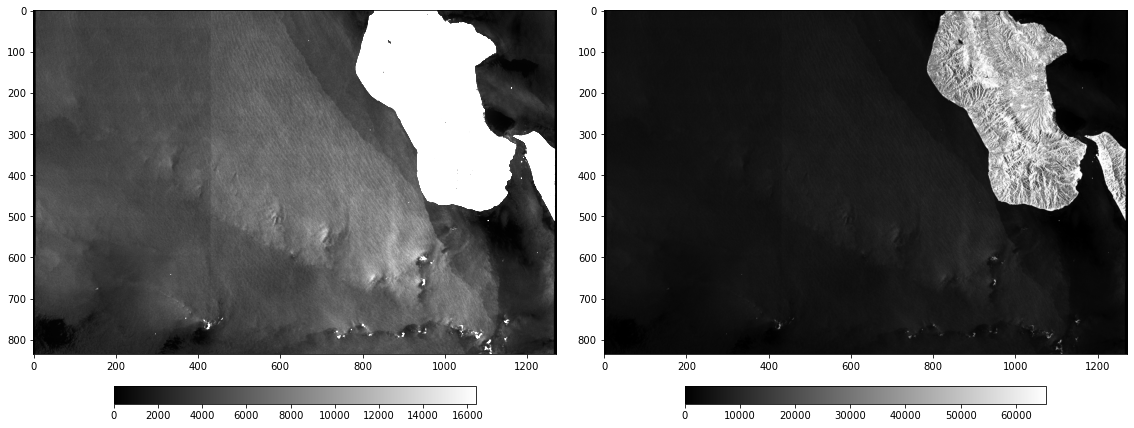

In [5]:
image = np.array(PIL.Image.open(f"res/{FILENAME}"))

plt.figure(figsize=(16,6))

plt.subplot(121)
plt.imshow(image, vmin=0, vmax=2**14, cmap="gray")
plt.colorbar(fraction=0.046, pad=0.08, orientation='horizontal')

plt.subplot(122)
plt.imshow(image, vmin=0, vmax=2**16, cmap="gray")
plt.colorbar(fraction=0.046, pad=0.08, orientation='horizontal')

plt.tight_layout()

plt.show()
plt.close()


In [6]:
import utm
from mpl_toolkits.basemap import Basemap

def get_distance(source_latitude, source_longitude, target_latitude, target_longitude):
    """
    Calculates the distance between two points on Earth using the Haversine formula.
    
    Parameters:
        source_latitude (float): The latitude of the source point in degrees.
        source_longitude (float): The longitude of the source point in degrees.
        target_latitude (float): The latitude of the target point in degrees.
        target_longitude (float): The longitude of the target point in degrees.
        
    Returns:
        float: The distance between the two points in kilometers.
    """
    EARTH_RADIUS = 6371

    d_lat = np.radians(target_latitude - source_latitude)
    d_lon = np.radians(target_longitude - source_longitude)
    a = (np.sin(d_lat / 2.) * np.sin(d_lat / 2.) +
         np.cos(np.radians(source_latitude)) * np.cos(np.radians(target_latitude)) *
         np.sin(d_lon / 2.) * np.sin(d_lon / 2.))
    c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
    d = EARTH_RADIUS * c
    return d


def grid_from_polygon(polygon, shape):
    """
    Generates a grid of points within a given polygon.
    
    Parameters:
        polygon (ndarray): A 2D array of shape (N, 2) containing the latitude and longitude coordinates of the vertices of the polygon in degrees.
        shape (tuple): A tuple of two integers representing the number of rows and columns in the output grid.
            
    Returns:
        tuple: A tuple containing two 2D arrays of floats of shape `shape` representing the latitude and longitude coordinates of the points in the grid.
    """
    
    # Convert polygon coordinates to UTM
    utm_easting, utm_northing, ZONE_NUMBER, ZONE_LETTER = utm.from_latlon(polygon[:, 1], polygon[:, 0])
    utm_polygon = np.stack((utm_easting, utm_northing), axis=1)

    easting_grid = np.zeros(shape)
    northing_grid = np.zeros(shape)

    def interpol_line(a, b, n):
        if a == b:
            return a
        else:
            return np.arange(a, b, (b - a) / n)[:n]

    # Interpolate along the top and bottom edges of the polygon
    v1 = utm_polygon[1]
    v2 = utm_polygon[2]
    easting_grid[0] = interpol_line(v1[1], v2[1], easting_grid.shape[1])
    northing_grid[0] = interpol_line(v1[0], v2[0], northing_grid.shape[1])

    v1 = utm_polygon[0]
    v2 = utm_polygon[3]
    easting_grid[-1] = interpol_line(v1[1], v2[1], easting_grid.shape[1])
    northing_grid[-1] = interpol_line(v1[0], v2[0], northing_grid.shape[1])

    for i in range(easting_grid.shape[1]):
        easting_grid[:, i] = interpol_line(easting_grid[0, i], easting_grid[-1, i], easting_grid.shape[0])
        northing_grid[:, i] = interpol_line(northing_grid[0, i], northing_grid[-1, i], northing_grid.shape[0])

    lat_grid, lon_grid = utm.to_latlon(northing_grid, easting_grid, ZONE_NUMBER, ZONE_LETTER, strict=False)
    return lat_grid, lon_grid


def get_iw_latlon(polygon, height=None, width=None, resolution=1):
    """
    Return the latitude and longitude arrays of a regular grid covering the specified polygon.

    Parameters:
        polygon (ndarray): A 2D array of shape (4, 2) containing the latitude and longitude coordinates of the vertices of the polygon in degrees.
        height (int, optional): The number of point in the first dimension of the grid.
        width (int, optional): The number of point in the second dimension of the grid.
        resolution (int, optional): The number of points per kilometer in the grid. Default is 1. Unused if height and width are provided

    Returns:
        owiLat (ndarray): A 2D array of latitude values for each point in the grid.
        owiLon (ndarray): A 2D array of longitude values for each point in the grid.
    """
    # resolution is the number of point per km
    if height is None:
        height = int(get_distance(polygon[0, 1], polygon[0, 0], polygon[1, 1], polygon[1, 0]) * resolution)
    if width is None:
        width = int(get_distance(polygon[0, 1], polygon[0, 0], polygon[-1, 1], polygon[-1, 0]) * resolution)
        
    owiLat, owiLon = grid_from_polygon(polygon, (height, width))
    return owiLat, owiLon

In [7]:
lat_grid, lon_grid = get_iw_latlon(polygon, height=image.shape[0], width=image.shape[1])

In [8]:
def initialize_map(lats, lons):
    """
    Initialize a map centered at the mean latitude and longitude of the given coordinates,
    with coastlines, map boundaries, and latitude and longitude lines drawn on it.

    Parameters:
        lats (ndarray): An array of latitude values.
        lons (ndarray): An array of longitude values.

    Returns:
        Basemap: object representing the initialized map.
    """
    # Get the minimum and maximum latitude and longitude values
    min_lat = np.min(lats)
    min_lon = np.min(lons)
    max_lat = np.max(lats)
    max_lon = np.max(lons)
    
    # Calculate the mean latitude and longitude
    lon_0 = (max_lon + min_lon) / 2
    lat_0 = (max_lat + min_lat) / 2

    # Calculate the range of latitudes and longitudes
    delta_lon = max_lon - min_lon
    delta_lat = max_lat - min_lat
    
    margin = 0.25
    min_lat -= delta_lat * margin
    max_lat += delta_lat * margin
    min_lon -= delta_lon * margin
    max_lon += delta_lon * margin

    # Initialize the map with the specified projection, resolution, and coordinates
    m = Basemap(
        projection="lcc",
        resolution='i',
        llcrnrlon=min_lon,
        llcrnrlat=min_lat,
        urcrnrlon=max_lon,
        urcrnrlat=max_lat,
        lon_0=lon_0,
        lat_0=lat_0,
        lon_1=max_lon,
        lat_1=max_lat
    )
    
    # Draw the coastlines, map boundaries, and latitude and longitude lines on the map
    m.drawcoastlines()
    m.drawmapboundary()

    # Calculate the intervals for the latitude and longitude lines
    stride = 1
    parallels = np.arange(min_lat // stride * stride, max_lat // stride * stride + stride, stride)
    meridians = np.arange(min_lon // stride * stride, max_lon // stride * stride + stride, stride)
    
    # Draw the latitude and longitude lines on the map
    m.drawparallels(parallels, labels=[False, True, True, False])
    m.drawmeridians(meridians, labels=[True, False, False, True])
    return m

In [9]:
def plot_on_map(data, lat_grid, lon_grid):
    """
    Plot the given data on a map, overlaid on a grayscale colormap. Optionally, draw a polygon
    on the map.

    Parameters:
    data (ndarray): A 2D array of data values to be plotted on the map.
    lat_grid (ndarray): A 2D array of latitude values for each point in the data.
    lon_grid (ndarray): A 2D array of longitude values for each point in the data.
    """
    
    # Initialize the plot with a figure size of 12x12 inches
    plt.figure(figsize=(12, 12))
    
    # Initialize the map with the given latitude and longitude grids
    m = initialize_map(lat_grid, lon_grid)

    # Plot the data on the map using a grayscale colormap
    colormesh = m.pcolormesh(lon_grid, lat_grid, data, latlon=True, shading='auto', cmap="gray", vmin=0, vmax=2**14)
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()
    
    # Close the plot to prevent it from being displayed multiple times
    plt.close()
    



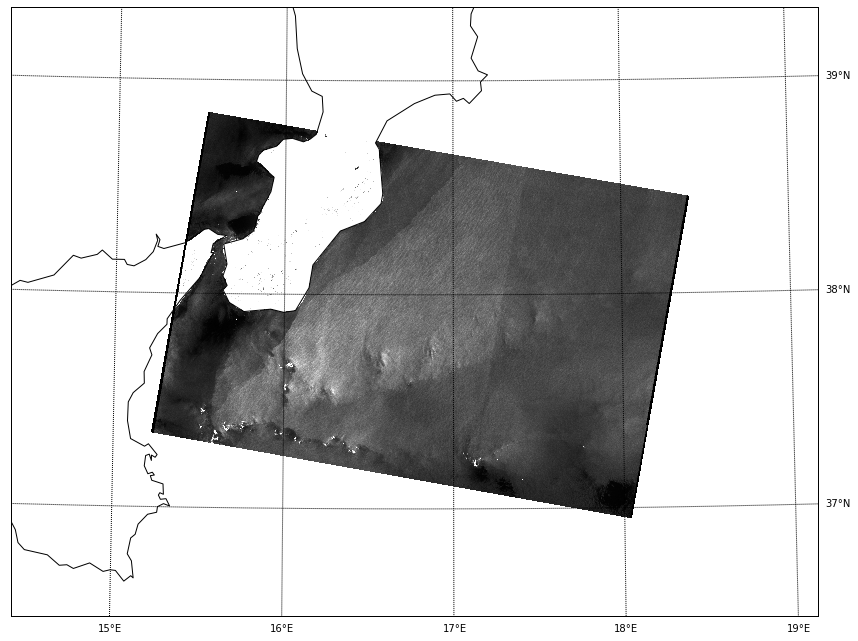

In [10]:
plot_on_map(image, lat_grid, lon_grid)